# Predicting solubility using the ATOM Modeling Pipeline (AMPL) on the public Delaney solubility dataset

In this notebook, we describe the AMPL used to curate a public dataset, fit a simple model to predict solubility from chemical structure, and predict solubility for withheld compounds.

## Set up
We first import the AMPL modules for use in this notebook.

The relevant AMPL modules for this example are listed below:

|module|Description|
|-|-|
|`atomsci.ddm.pipeline.model_pipeline`|The model pipeline module is used to fit models and load models for prediction.|
|`atomsci.ddm.pipeline.parameter_parser`|The parameter parser reads through pipeline options for the model pipeline.|
|`atomsci.ddm.utils.curate_data`|The curate data module is used for data loading and pre-processing.|
|`atomsci.ddm.utils.struct_utils`|The structure utilities module is used to process loaded structures.|
|`atomsci.ddm.pipeline.perf_plots`|Perf plots contains a variety of plotting functions.|

In [1]:
# We temporarily disable warnings for demonstration.
# FutureWarnings and DeprecationWarnings are present from some of the AMPL dependency modules.
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np
import pandas as pd
import os
import requests
import sys

import atomsci.ddm.pipeline.model_pipeline as mp
import atomsci.ddm.pipeline.parameter_parser as parse
import atomsci.ddm.utils.curate_data as curate_data
import atomsci.ddm.utils.struct_utils as struct_utils
from atomsci.ddm.pipeline import perf_plots as pp


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/home/jupyter/atomsci/lib/python3.8/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
DEBUG:ATOM:Model tracker client not supported in your environment; will save models in filesystem only.


## Data curation

We then download and do very simple curation to the related dataset.

We need to set the directory we want to save files to. Next we download the dataset.

In [2]:
pwd

'/home/jupyter/Summer_AMPL/Renate'

In [3]:
working_dir = '/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm'

In [4]:
# Download the Delaney dataset
!wget 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv' -P /home/jupyter/Summer_AMPL/AMPL/atomsci/ddm

--2023-06-14 15:11:20--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 3.5.161.152
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|3.5.161.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/csv]
Saving to: ‘/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney-processed.csv.3’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.1s    

2023-06-14 15:11:20 (686 KB/s) - ‘/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney-processed.csv.3’ saved [96699/96699]



Next, we load the downloaded dataset, and process the compound structures:

In [5]:
# Load the Delaney dataset
dataset_file = os.path.join(working_dir, 'delaney-processed.csv')
raw_df = pd.read_csv(dataset_file)

# Generate SMILES, InChI keys for dataset with curation and structure modules.
# RDkit modules are used to process the SMILES strings
raw_df['rdkit_smiles'] = raw_df['smiles'].apply(curate_data.base_smiles_from_smiles)
raw_df['inchi_key'] = raw_df['smiles'].apply(struct_utils.smiles_to_inchi_key)

data = raw_df
data['compound_id'] = data['inchi_key']

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Charges were rearranged

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Charges were rearranged

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Charges were rearranged

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Charges were rearranged; Omitted undefined stereo

[15:11:28] WARNING: Charges were rearranged

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WARNING: Omitted undefined stereo

[15:11:28] WA

The next step is to address the case where we have multiple measurements for a single structure (by RDkit canonical SMILEs string). We have a function in the `curate_data()` module to address process compounds. The function parameters are listed below along with an explanation of each parameter:

In [6]:
# column: Response values column
column = 'measured log solubility in mols per litre'

# tolerance: Percentage of individual respsonse values allowed to different from the average to be included in averaging
tolerance = 10

# list_bad_duplicates: Print structures with bad duplicates
list_bad_duplicates = 'Yes'

# max_std: Maximum allowed standard deviation for computed average response value
# NOTE: In this example, we set this value very high to disable this feature
max_std = 100000

# compound_id: Compound ID column
compound_id = 'compound_id'

# smiles_col: SMILES column
smiles_col = 'rdkit_smiles'

curated_df = curate_data.average_and_remove_duplicates(column, tolerance, list_bad_duplicates, data, max_std,
                                                       compound_id=compound_id, smiles_col=smiles_col)
curated_file = os.path.join(working_dir, 'delaney_curated.csv')
curated_df.to_csv(curated_file, index=False)

Bad duplicates removed from dataset
Dataframe size (1126, 17)
List of 'bad' duplicates removed
                     compound_id  measured log solubility in mols per litre  \
233  FBPFZTCFMRRESA-UHFFFAOYSA-N                                       0.06   
276  FBPFZTCFMRRESA-UHFFFAOYSA-N                                       1.09   

     VALUE_NUM_mean   Perc_Var  VALUE_NUM_std  
233           0.575  89.565217        0.72832  
276           0.575  89.565217        0.72832  

Dataset de-duplicated
Dataframe size (1116, 17)
New column created with averaged values:  VALUE_NUM_mean


Now that we have a curated dataset, we decide what type of featurizer and model we would like. See documentation for all available options. We also set the name of the new averaged response value column.

In [7]:
featurizer = 'ecfp'
model_type = 'RF'
response_cols = ['VALUE_NUM_mean']

Next we set up the parameters for our model. We set datastore and save_results to False to indicate that we are reading the input file and saving the results directly to the file system. There are a wide range of settable parameters; see the documentation for more details.

In [8]:
params={"datastore": "False",
        "save_results": "False",
        "id_col": compound_id,
        "smiles_col": smiles_col,
        "response_cols": response_cols,
        "featurizer": featurizer,
        "model_type": model_type,
        "result_dir": working_dir,
        "dataset_key": curated_file}

We use parse.wrapper to process our input configuration. We then build the model pipeline, train the model, and plot the predicted versus true values for our train, valid, test sets.

INFO:ATOM:Created a dataset hash '4ce458d60e68a743c0b57860ef433270' from dataset_key '/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated.csv'
DEBUG:ATOM:Attempting to load featurized dataset
DEBUG:ATOM:Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
INFO:ATOM:Featurized dataset not previously saved for dataset delaney_curated, creating new
INFO:ATOM:Featurizing sample 0
INFO:ATOM:Featurizing sample 1000
DEBUG:ATOM:Number of features: 1024
INFO:ATOM:Wrote transformers to /home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/RF_ecfp_scaffold_regression/8d1979ad-f565-4123-9e74-846e1400dd11/transformers.pkl
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming response data
INFO:ATOM:Fitting random forest model
INFO:ATOM:Fold 0: training r2_score = 0.946, validation r2_score = 0.289, test r2_score = 0.381
INFO:ATOM:Wrote model tarball to /home/jupyter/Summer_AMPL/AMPL/atom

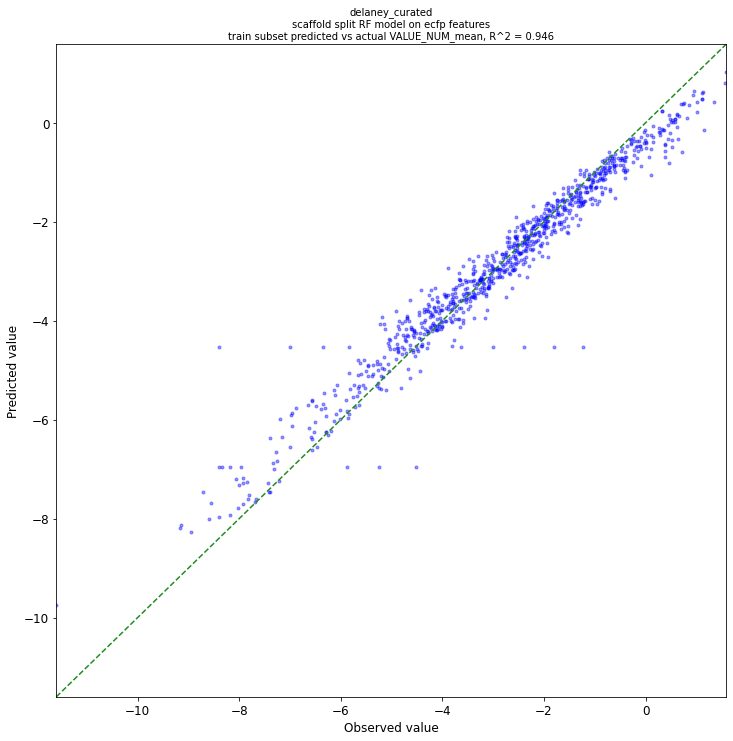

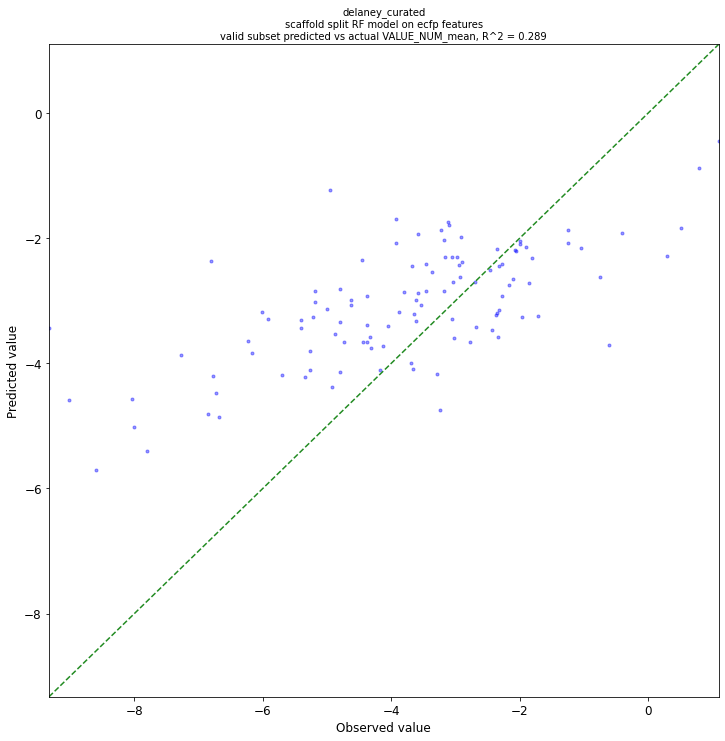

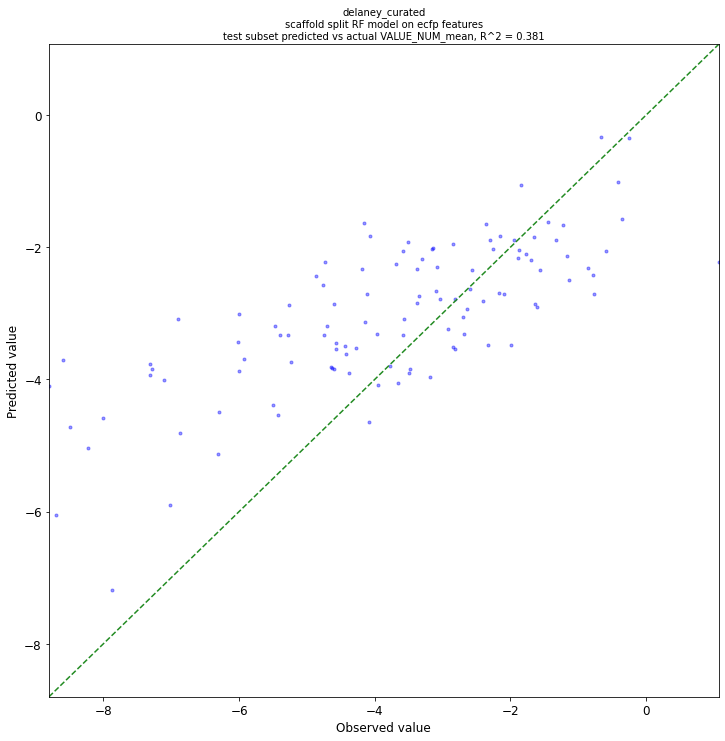

In [9]:
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
MP.train_model()
pp.plot_pred_vs_actual(MP)

INFO:ATOM:Created a dataset hash '4ce458d60e68a743c0b57860ef433270' from dataset_key '/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated.csv'
DEBUG:ATOM:Attempting to load featurized dataset
DEBUG:ATOM:Exception when trying to load featurized data:
DynamicFeaturization doesn't support get_featurized_dset_name()
INFO:ATOM:Featurized dataset not previously saved for dataset delaney_curated, creating new
INFO:ATOM:Featurizing sample 0
INFO:ATOM:Featurizing sample 1000
DEBUG:ATOM:Number of features: 1024
INFO:ATOM:Wrote transformers to /home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/NN_ecfp_scaffold_regression/c16da5a7-1417-4281-9146-b766ef96306d/transformers.pkl
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming response data
INFO:ATOM:Transforming response data
INFO:ATOM:Total score for epoch 0 is -0.49
INFO:ATOM:Epoch 0: training r2_score = -0.015, validation r2_score = -0.490, test r2_score = -0.415
INFO:ATOM:*** Total score for epoch 1 is 0.0894, is new max

['/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/NN_ecfp_scaffold_regression/c16da5a7-1417-4281-9146-b766ef96306d/model/checkpoint1.pt', '/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/NN_ecfp_scaffold_regression/c16da5a7-1417-4281-9146-b766ef96306d/model/checkpoint2.pt', '/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/NN_ecfp_scaffold_regression/c16da5a7-1417-4281-9146-b766ef96306d/model/checkpoint3.pt', '/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/NN_ecfp_scaffold_regression/c16da5a7-1417-4281-9146-b766ef96306d/model/checkpoint4.pt', '/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/NN_ecfp_scaffold_regression/c16da5a7-1417-4281-9146-b766ef96306d/model/checkpoint5.pt']
/home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated/NN_ecfp_scaffold_regression/c16da5a7-1417-4281-9146-b766ef96306d/model/checkpoint1.pt


INFO:ATOM:Wrote model tarball to /home/jupyter/Summer_AMPL/AMPL/atomsci/ddm/delaney_curated_model_c16da5a7-1417-4281-9146-b766ef96306d.tar.gz


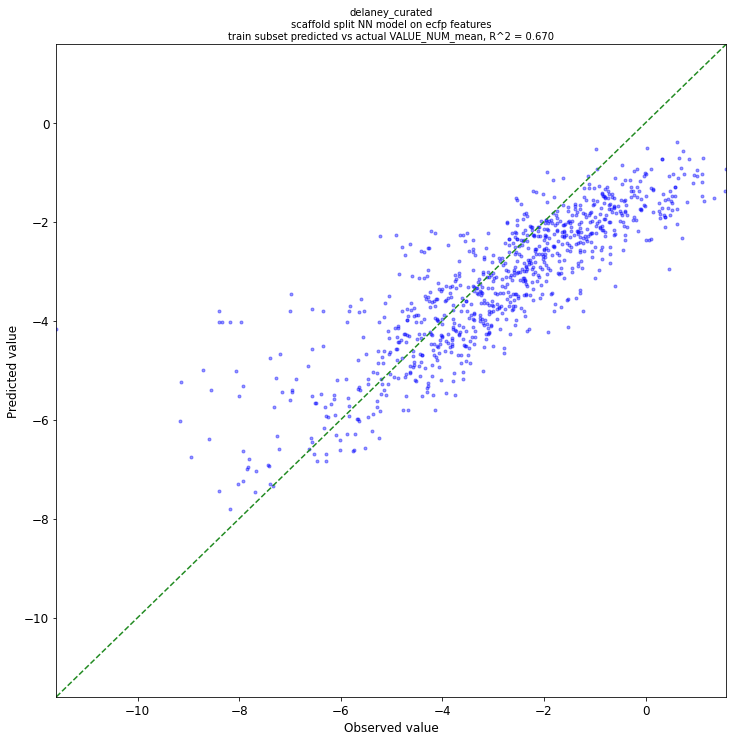

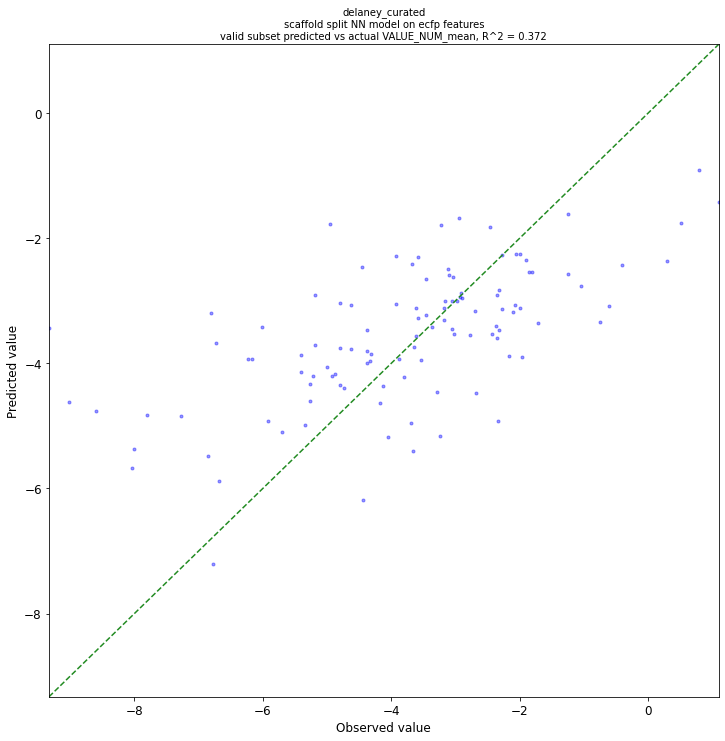

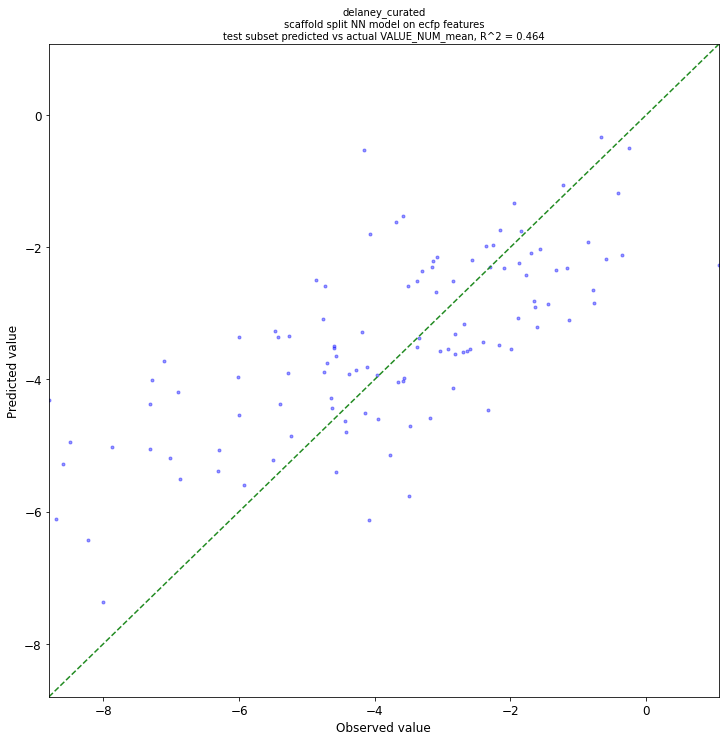

In [10]:
# nn will be slow without a GPU
params['model_type'] = 'NN'
pparams = parse.wrapper(params)
MP = mp.ModelPipeline(pparams)
MP.train_model()
pp.plot_pred_vs_actual(MP)